In [1]:
using Revise
using Bilevel

using RigidBodyDynamics
using MeshCatMechanisms
using MeshCat
using Plots
using LinearAlgebra
using StaticArrays
using BenchmarkTools
using LaTeXStrings

┌ Info: Precompiling Bilevel [9688c538-179f-11e9-3174-495cea6b7f67]
└ @ Base loading.jl:1186


HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/b464848323e0a4c9a3cfe11f8edca2932188b6d9-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/b464848323e0a4c9a3cfe11f8edca2932188b6d9-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

┌ Error: evaluation error
│   mod = Bilevel
│   ex = const usrfun = #= /home/blandry/.julia/dev/Bilevel/src/solvers/snopt.jl:154 =# @cfunction(objcon_wrapper, Cvoid, (Ptr{Clong}, Ref{Clong}, Ptr{Cdouble}, Ref{Clong}, Ref{Clong}, Ptr{Cdouble}, Ref{Clong}, Ref{Clong}, Ptr{Cdouble}, Ptr{Cchar}, Ref{Clong}, Ptr{Clong}, Ref{Clong}, Ptr{Cdouble}, Ref{Clong}))
│   exception = (ErrorException("invalid lookup expr (\$(QuoteNode(Core.svec)))(JuliaInterpreter.SSAValue(2), JuliaInterpreter.SSAValue(3), JuliaInterpreter.SSAValue(4), JuliaInterpreter.SSAValue(5), JuliaInterpreter.SSAValue(6), JuliaInterpreter.SSAValue(7), JuliaInterpreter.SSAValue(8), JuliaInterpreter.SSAValue(9), JuliaInterpreter.SSAValue(10), JuliaInterpreter.SSAValue(11), JuliaInterpreter.SSAValue(12), JuliaInterpreter.SSAValue(13), JuliaInterpreter.SSAValue(14), JuliaInterpreter.SSAValue(15), JuliaInterpreter.SSAValue(16))"), Union{Ptr{Nothing}, InterpreterIP}[Ptr{Nothing} @0x00007f249ce055eb, Ptr{Nothing} @0x00007f249cdd6204, P

# Simulation of sliding box

In [ ]:
urdf = joinpath("..", "..", "urdf", "ball2d.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, 1.)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles);

In [ ]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf))
# open(mvis)

In [ ]:
N = 10
Δt = 0.1
q0 = [0., 0.2, 0.]
v0 = [8., 0., 0.];

In [ ]:
# Indirect

sim_data = get_sim_data_indirect(mechanism,env,Δt,relax_comp=true)
null_ctrl! = (u,t,x) -> u[:] .= 0.
x0 = MechanismState(mechanism)
set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)
sim_indirect = Bilevel.simulate(sim_data,null_ctrl!,x0,N)

In [ ]:
@benchmark sim_indirect = Bilevel.simulate(sim_data,null_ctrl!,x0,N)

In [ ]:
setanimation!(mvis, sim_indirect[6], sim_indirect[1])

In [ ]:
# Direct (both normal and friction)

sim_data = get_sim_data_direct(mechanism,env,Δt)
null_ctrl! = (u,t,x) -> u[:] .= 0.
x0 = MechanismState(mechanism)
set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)
sim_direct = Bilevel.simulate(sim_data,null_ctrl!,x0,N)

In [ ]:
@benchmark sim_direct = Bilevel.simulate(sim_data,null_ctrl!,x0,N)

In [ ]:
setanimation!(mvis, sim_direct[6], sim_direct[1])

In [ ]:
j = 1
plot(sim_indirect[6],sim_indirect[8][j,:],label="Indirect",seriescolor=RGB(((227,74,51) ./ 255.)...),linewidth=0,marker=6)
plot!(sim_direct[6],sim_direct[8][j,:],label="Direct",seriescolor=RGB(((254,232,200) ./ 255.)...),linewidth=1,marker=4)

In [ ]:
sim_indirect[1][end]

# Trajectory optimization of sliding box

In [3]:
urdf = joinpath("..", "..", "urdf", "ball2d.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, 1.)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles);

In [ ]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf))
# open(mvis)

In [ ]:
# qN = [3.0, 0., 0.]
# N = 10

# qN = [3.0, 0., 0.]
# N = 15

qN = [3.0, 0., 0.]
N = 20

# qN = [3.0, 0., 0.]
# N = 25

# qN = [5.0, 0., 0.]
# N = 30

# qN = [10.0, 0., 0.]
# N = 35

# qN = [15.0, 0., 0.]
# N = 40

q1 = [0., 0.2, 0.]
Δt = 0.1

q_min = [-10., -10., -10.]
q_max = [10., 10., 10.]

function get_prob_limits(sim_data)
    x_min = -1e19*ones(sim_data.vs.num_vars)
    x_max = 1e19*ones(sim_data.vs.num_vars)
    
    # joint limits
    add_box_con_snopt!(x_min, x_max, sim_data, :q, q_min, q_max, 1:N)
    add_box_con_snopt!(x_min, x_max, sim_data, :h, [Δt], [Δt], 1:N-1)
    
    # torques limits
    add_box_con_snopt!(x_min, x_max, sim_data, :u, zeros(num_velocities(mechanism)), zeros(num_velocities(mechanism)), 1:N-1)

    x_min, x_max
end

function add_prob_constraints!(sim_data)
    vs = sim_data.vs

    add_eq!(sim_data, :cq1, length(q1), x -> vs(x, :q1) - q1)
    add_eq!(sim_data, :cv1, 1, x -> vs(x, :v1)[2])
    add_eq!(sim_data, :cqN, 2, x -> vs(x, Symbol("q", N))[1:2] - qN[1:2])
    add_eq!(sim_data, :cvN, 1, x -> vs(x, Symbol("v", N))[1])
end

function get_prob_init(sim_data)
    x0 = zeros(sim_data.vs.num_vars)
    for n = 1:N
        x0[sim_data.vs(Symbol("q", n))] .= n/N*(qN - q1) + q1
    end
    
    x0
end

In [ ]:
# Indirect
con_tol = 1e-5
obj_tol = 1e-5
max_iter = 5000

sim_data = get_trajopt_data_indirect(mechanism,env,Δt,N,relax_comp=true)
add_prob_constraints!(sim_data)
x_min, x_max = get_prob_limits(sim_data)
x0 = get_prob_init(sim_data)

@time traj_indirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)

In [ ]:
function run_trajopt()
    Bilevel.solve_rosenbrock() # clearing SNOPT
    Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=0, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)
end

@benchmark run_trajopt()

In [ ]:
Bilevel.solve_rosenbrock(); # clearing SNOPT

In [ ]:
# Semidirect
con_tol = 1e-5
obj_tol = 1e-5
max_iter = 5000

sim_data = get_trajopt_data_semidirect(mechanism,env,Δt,N,relax_comp=false)
add_prob_constraints!(sim_data)
x_min, x_max = get_prob_limits(sim_data)
x0 = get_prob_init(sim_data)
@time traj_semidirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)

In [ ]:
function run_trajopt()
    Bilevel.solve_rosenbrock() # clearing SNOPT
    Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=0, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)
end

@benchmark run_trajopt()

In [ ]:
j = 1
xlabel=latexstring("t")
ylabel=latexstring("x")
plot(traj_indirect[7],traj_indirect[8][j,:],label="Indirect",seriescolor=RGB(((227,74,51) ./ 255.)...),linewidth=6,marker=6,xlabel=xlabel)
plot!(traj_semidirect[7],traj_semidirect[8][j,:],label="Semidirect",seriescolor=RGB(((254,232,200) ./ 255.)...),linewidth=1,marker=6,ylabel=ylabel)

In [ ]:
savefig(string("slidingbox_x_08-28-19_3.svg")) 

In [ ]:
j = 2
xlabel=latexstring("t")
ylabel=latexstring("z")
plot(traj_indirect[7],traj_indirect[8][j,:],label="Indirect",seriescolor=RGB(((227,74,51) ./ 255.)...),linewidth=6,marker=6,xlabel=xlabel)
plot!(traj_semidirect[7],traj_semidirect[8][j,:],label="Semidirect",seriescolor=RGB(((254,232,200) ./ 255.)...),linewidth=1,marker=6,ylabel=ylabel)

In [ ]:
savefig(string("slidingbox_z_08-28-19_3.svg")) 

In [ ]:
display(traj_indirect[2][end])
display(traj_semidirect[2][end])

In [ ]:
display(length(traj_indirect[9]))
display(length(traj_semidirect[9]))

# Trajectory optimization of jumper robot

In [25]:
urdf = joinpath("..", "..", "urdf", "jumper", "jumper.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, 100.)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles);

In [26]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf));
open(mvis)

┌ Info: Serving MeshCat visualizer at http://127.0.0.1:8701
└ @ MeshCat /home/blandry/.julia/packages/MeshCat/WlA0B/src/servers.jl:24


Process(`xdg-open http://127.0.0.1:8701`, ProcessExited(0))

Created new window in existing browser session.


Error handling websocket connection:
WebSockets.WebSocketClosedError("ws|server respond to OPCODE_CLOSE 1001:Going Away")
Stacktrace:
 [1] try_yieldto(::typeof(Base.ensure_rescheduled), ::Base.RefValue{Task}) at ./event.jl:196
 [2] wait() at ./event.jl:255
 [3] wait(::Condition) at ./event.jl:46
 [4] wait(::Task) at ./task.jl:188
 [5] create_socket(::Dict{Any,Any}) at /home/blandry/.julia/packages/WebIO/Rk8wc/src/providers/mux.jl:44
 [6] (::getfield(Mux, Symbol("##5#6")){getfield(Mux, Symbol("##28#29")){Array{SubString{String},1}},typeof(WebIO.create_socket)})(::Function, ::Dict{Any,Any}) at /home/blandry/.julia/packages/Mux/FeATY/src/Mux.jl:17
 [7] #1 at /home/blandry/.julia/packages/Mux/FeATY/src/Mux.jl:10 [inlined]
 [8] splitquery(::getfield(Mux, Symbol("##1#2")){getfield(Mux, Symbol("##5#6")){getfield(Mux, Symbol("##28#29")){Array{SubString{String},1}},typeof(WebIO.create_socket)},getfield(Mux, Symbol("##1#2")){typeof(Mux.wclose),getfield(Mux, Symbol("##1#2")){getfield(Mux, Symbol(

In [27]:
set_configuration!(mvis, [0., -2, .6, -1.2])

In [28]:
N = 10
Δt = 0.05
q0 = [0., -2, .6, -1.2]
v0 = zeros(num_velocities(mechanism))

sim_data = get_sim_data_indirect(mechanism,env,Δt)
null_ctrl! = (u,t,x) -> u[:] .= 0.
x0 = MechanismState(mechanism)
set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)
traj_sim = Bilevel.simulate(sim_data,null_ctrl!,x0,N)
setanimation!(mvis, traj_sim[6], traj_sim[1])

In [74]:
q_nom = copy(traj_sim[1][end])
q_min = min.(q_nom, [-20., -10., -pi, -pi])
q_max = max.(q_nom, [20., -0.25, pi, pi])

N = 20
Δt = 0.025

function add_prob_constraints!(sim_data)
    vs = sim_data.vs

    add_eq!(sim_data, :cq1x, 4, x -> vs(x, :q1)[1:4] - q_nom[1:4])
    add_eq!(sim_data, :cv1, num_velocities(mechanism), x -> vs(x, :v1))
    
#     add_eq!(sim_data, :cqNx, 1, x -> 1. - vs(x, Symbol("q", N))[1])
    add_eq!(sim_data, :cqNy, 1, x -> -1.25 - vs(x, Symbol("q", N))[2])
#     add_ineq!(sim_data, :cqNx, 1, x -> vs(x, Symbol("q", N))[1] - (-1.))
end

function add_prob_obj!(sim_data)
    vs = sim_data.vs    

#     add_obj!(sim_data, :cqN, x -> -vs(x, Symbol("q", N))[1])
end

function get_prob_limits(sim_data)
    x_min = -1e19*ones(sim_data.vs.num_vars)
    x_max = 1e19*ones(sim_data.vs.num_vars)
    
    # joint limits
    add_box_con_snopt!(x_min, x_max, sim_data, :q, q_min, q_max, 1:N)
    add_box_con_snopt!(x_min, x_max, sim_data, :h, [Δt], [Δt], 1:N-1)
    
    # torques limits
#     u_limit = [0.,0.,0.,100.]
    u_limit = [0.,0.,0.,100.]
    add_box_con_snopt!(x_min, x_max, sim_data, :u, -u_limit .* ones(num_velocities(mechanism)), u_limit .* ones(num_velocities(mechanism)), 1:N-1)
    
    x_min, x_max
end

function get_prob_init(sim_data)
    x0 = zeros(sim_data.vs.num_vars)
    for n = 1:N
        qn = copy(q_nom)
        x0[sim_data.vs(Symbol("q", n))] .= qn
    end
    
    x0
end

function setup_prob!(sim_data)
    add_prob_constraints!(sim_data)
    add_prob_obj!(sim_data)
    x_min, x_max = get_prob_limits(sim_data)
    x0 = get_prob_init(sim_data)
    
    x0, x_min, x_max
end

setup_prob! (generic function with 1 method)

In [75]:
# Semidirect

sim_data = get_trajopt_data_semidirect(mechanism,env,Δt,N,relax_comp=false)
x0, x_min, x_max = setup_prob!(sim_data);

In [76]:
con_tol = 1e-4
obj_tol = 1e-4
max_iter = 5000

display(@time traj_semidirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter))

x0 = traj_semidirect[9]

setanimation!(mvis, traj_semidirect[7], traj_semidirect[1])

(Array{Float64,1}[[-0.000433986, -1.31017, 0.599126, -1.22255], [-0.00626287, -1.32482, 0.577135, -1.19002], [-0.0246263, -1.38207, 0.500334, -1.05484], [-0.0442225, -1.43087, 0.424496, -0.925711], [-0.0670988, -1.47866, 0.33969, -0.778006], [-0.0919239, -1.51987, 0.251828, -0.624464], [-0.115795, -1.551, 0.176188, -0.527876], [-0.135697, -1.57102, 0.128736, -0.573249], [-0.154745, -1.58275, 0.0873691, -0.653167], [-0.17542, -1.5883, 0.037621, -0.692097], [-0.199505, -1.58864, -0.0290791, -0.642537], [-0.22304, -1.58097, -0.0915667, -0.613638], [-0.246853, -1.5659, -0.154735, -0.580084], [-0.270472, -1.54328, -0.21659, -0.55245], [-0.298406, -1.51364, -0.302011, -0.406519], [-0.32877, -1.47408, -0.40636, -0.1702], [-0.355527, -1.42661, -0.492014, -0.0243492], [-0.378699, -1.37351, -0.554321, 0.0103967], [-0.399219, -1.31484, -0.599305, -0.036961], [-0.417432, -1.25, -0.631954, -0.143938]], Array{Float64,1}[[0.0, 8.4368e-14, 0.0, 0.0], [-0.515057, -0.363762, -0.879647, 1.30109], [-1.743

Finished successfully: optimality conditions satisfied
 18.027406 seconds (68.89 M allocations: 11.186 GiB, 20.77% gc time)


In [77]:
qi = 1

1

In [97]:
q = traj_semidirect[1][qi]
set_configuration!(mvis, q) 
qi += 1

21

In [621]:
maximum(abs.(vcat(traj_semidirect[2]...)))

19.362541645641254

In [611]:
maximum(abs.(vcat(traj_semidirect[3]...)))

65.08838511760261

In [98]:
function run_trajopt()
    Bilevel.solve_rosenbrock() # clearing SNOPT
    Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=0, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)
end

@benchmark run_trajopt()

BenchmarkTools.Trial: 
  memory estimate:  219.24 MiB
  allocs estimate:  1001848
  --------------
  minimum time:     326.573 ms (20.44% GC)
  median time:      328.166 ms (20.50% GC)
  mean time:        374.348 ms (30.21% GC)
  maximum time:     490.841 ms (46.37% GC)
  --------------
  samples:          14
  evals/sample:     1

In [99]:
# Indirect

sim_data = get_trajopt_data_indirect(mechanism,env,Δt,N,relax_comp=true)
x0, x_min, x_max = setup_prob!(sim_data);

In [100]:
con_tol = 1e-4
obj_tol = 1e-4
max_iter = 5000

display(@time traj_inidirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter))

x0 = traj_inidirect[9]

setanimation!(mvis, traj_inidirect[7], traj_inidirect[1])

(Array{Float64,1}[[-0.000433986, -1.31017, 0.599126, -1.22255], [-0.013058, -1.3513, 0.543829, -1.12941], [-0.0338707, -1.41101, 0.455594, -0.979702], [-0.0568534, -1.46362, 0.364924, -0.826519], [-0.08134, -1.50711, 0.273978, -0.673751], [-0.107204, -1.54145, 0.182275, -0.520712], [-0.132763, -1.56647, 0.0967036, -0.379713], [-0.163372, -1.58252, -0.00941425, -0.204058], [-0.191461, -1.5899, -0.10061, -0.0560795], [-0.214113, -1.59084, -0.163317, 0.0409531], [-0.224184, -1.58776, -0.163141, 0.0276343], [-0.222843, -1.57947, -0.104944, -0.134032], [-0.220641, -1.5638, -0.0460457, -0.289934], [-0.220094, -1.54193, 0.00030554, -0.384237], [-0.21657, -1.5115, 0.0632226, -0.552175], [-0.21151, -1.47157, 0.129109, -0.743698], [-0.208386, -1.42724, 0.181187, -0.858062], [-0.204753, -1.37578, 0.234072, -0.976669], [-0.199831, -1.31582, 0.292112, -1.12589], [-0.195373, -1.25, 0.345268, -1.25412]], Array{Float64,1}[[-1.54816e-13, 1.61179e-13, 0.0, 0.0], [-1.28338, -1.1466, -2.2119, 3.7257], [-1

Resource limit error: iteration limit reached
  4.271507 seconds (22.46 M allocations: 2.714 GiB, 24.77% gc time)


In [101]:
function run_trajopt()
    Bilevel.solve_rosenbrock() # clearing SNOPT
    Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=0, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)
end

@benchmark run_trajopt()

BenchmarkTools.Trial: 
  memory estimate:  438.55 MiB
  allocs estimate:  2382486
  --------------
  minimum time:     673.517 ms (43.02% GC)
  median time:      677.252 ms (42.84% GC)
  mean time:        678.270 ms (42.82% GC)
  maximum time:     687.413 ms (42.48% GC)
  --------------
  samples:          8
  evals/sample:     1

# Trajectory optimization of little dog

In [102]:
urdf = joinpath("..", "..", "urdf", "little_dog", "little_dog2d.urdf")
mechanism = parse_urdf(Float64, urdf)

floor = findbody(mechanism, "floor")
point = Point3D(default_frame(floor), SVector([0.,0.,0.]...))
normal = FreeVector3D(default_frame(floor), SVector([0.,0.,1.]...))
floor_obs = Obstacle(floor, point, normal, :xyz, 1.)

obstacles = [floor_obs]
env = Environment(mechanism, urdf, obstacles);

In [103]:
mvis = MechanismVisualizer(mechanism, URDFVisuals(urdf));
open(mvis)

┌ Info: Serving MeshCat visualizer at http://127.0.0.1:8702
└ @ MeshCat /home/blandry/.julia/packages/MeshCat/WlA0B/src/servers.jl:24


Process(`xdg-open http://127.0.0.1:8702`, ProcessExited(0))

Created new window in existing browser session.


Error handling websocket connection:
WebSockets.WebSocketClosedError("ws|server respond to OPCODE_CLOSE 1001:Going Away")
Stacktrace:
 [1] try_yieldto(::typeof(Base.ensure_rescheduled), ::Base.RefValue{Task}) at ./event.jl:196
 [2] wait() at ./event.jl:255
 [3] wait(::Condition) at ./event.jl:46
 [4] wait(::Task) at ./task.jl:188
 [5] create_socket(::Dict{Any,Any}) at /home/blandry/.julia/packages/WebIO/Rk8wc/src/providers/mux.jl:44
 [6] (::getfield(Mux, Symbol("##5#6")){getfield(Mux, Symbol("##28#29")){Array{SubString{String},1}},typeof(WebIO.create_socket)})(::Function, ::Dict{Any,Any}) at /home/blandry/.julia/packages/Mux/FeATY/src/Mux.jl:17
 [7] #1 at /home/blandry/.julia/packages/Mux/FeATY/src/Mux.jl:10 [inlined]
 [8] splitquery(::getfield(Mux, Symbol("##1#2")){getfield(Mux, Symbol("##5#6")){getfield(Mux, Symbol("##28#29")){Array{SubString{String},1}},typeof(WebIO.create_socket)},getfield(Mux, Symbol("##1#2")){typeof(Mux.wclose),getfield(Mux, Symbol("##1#2")){getfield(Mux, Symbol(

In [108]:
N = 8
Δt = 0.025
# q0 = [0., -.275, 0., 0.25, -0.25, 0.25, -0.25, pi/4, pi/4, -pi/4, -pi/4, -pi/2, -pi/2, pi/2, pi/2] 
q0 = [0., -.25, 0., 0.25, -0.25, 0.25, -0.25, pi/4, pi/4, pi/4, pi/4, -pi/2, -pi/2, -pi/2, -pi/2] 
v0 = zeros(num_velocities(mechanism))

sim_data = get_sim_data_indirect(mechanism,env,Δt)
null_ctrl! = (u,t,x) -> u[:] .= 0.
x0 = MechanismState(mechanism)
set_configuration!(x0, q0)
set_velocity!(x0, v0)
setdirty!(x0)
traj_sim = Bilevel.simulate(sim_data,null_ctrl!,x0,N)
setanimation!(mvis, traj_sim[6], traj_sim[1])

In [106]:
set_configuration!(mvis, [0.1, -.15, 0., 0.25, -0.25, 0.25, -0.25, 0, 0, 0, 0, 0, 0, 0, 0])

In [110]:
q_nom

15-element Array{Float64,1}:
  0.00010664238487750007
 -0.07776629311365948   
  0.004698826959189465  
  0.21523577005700045   
 -0.21524000150324477   
  0.2423499060108737    
 -0.23788561566104177   
  0.8364976984980046    
  0.8364954444720863    
  0.8044417218579732    
  0.8050645931556184    
 -2.332764703327538     
 -2.3327619139044327    
 -1.771089276432456     
 -1.7807521498957235    

In [111]:
q_nom = copy(traj_sim[1][end])
q_min = min.(q_nom, [-5., -.5, -0.1*pi, 0.25, -0.25, 0.25, -0.25, -3.5, -3.5, -3.5, -3.5, -3.1, -3.1, -3.1, -3.1])
q_max = max.(q_nom, [5., -0.07, 0.1*pi, 0.25, -0.25, 0.25, -0.25, 2.4, 2.4, 2.4, 2.4, 1., 1., 1., 1.])

# q_min = min.(q_nom, [-5., -.5, -0.02*pi, 0.25, -0.25, 0.25, -0.25, -1., -1., -1., -1., -3.1, -3.1, -3.1, -3.1])
# q_max = max.(q_nom, [5., -0.1, 0.02*pi, 0.25, -0.25, 0.25, -0.25, 1., 1., 1., 1., 1., 1., 1., 1.])

# x_goal = 0.2
# N = 10
# Δt = 0.1

# x_goal = .15
# N = 14
# Δt = 0.05

x_goal = 0.25
N = 12
Δt = 0.05

function add_prob_constraints!(sim_data)
    vs = sim_data.vs

    add_eq!(sim_data, :cq1x, 1, x -> vs(x, :q1)[1])
#     add_eq!(sim_data, :cq1, 15, x -> q_nom - vs(x, :q1))
    add_eq!(sim_data, :cv1, num_velocities(mechanism), x -> vs(x, :v1))

    add_ineq!(sim_data, :cqNx, 1, x -> x_goal - vs(x, Symbol("q", N))[1])
    
    add_eq!(sim_data, :cqN, num_positions(mechanism)-1, x -> vs(x, Symbol("q", N))[2:end] - vs(x, :q1)[2:end])
    add_eq!(sim_data, :cvN, num_velocities(mechanism), x -> vs(x, Symbol("v", N)))

#     for n = 1:N
#         add_eq!(sim_data, Symbol("cqSym1_", n), 1, x -> vs(x, Symbol("q", n))[8] + vs(x, Symbol("q", n))[11])
#         add_eq!(sim_data, Symbol("cqSym2_", n), 1, x -> vs(x, Symbol("q", n))[9] + vs(x, Symbol("q", n))[10])
#         add_eq!(sim_data, Symbol("cqSym3_", n), 1, x -> vs(x, Symbol("q", n))[12] - vs(x, Symbol("q", n))[15]) 
#         add_eq!(sim_data, Symbol("cqSym4_", n), 1, x -> vs(x, Symbol("q", n))[13] - vs(x, Symbol("q", n))[14]) 
#     end
    
#     for n = 1:N-1
#         add_eq!(sim_data, Symbol("cnSym1_", n), 1, x -> vs(x, Symbol("c_n1_", n)) - vs(x, Symbol("c_n4_", n)))
#         add_eq!(sim_data, Symbol("cnSym2_", n), 1, x -> vs(x, Symbol("c_n2_", n)) - vs(x, Symbol("c_n3_", n)))
#     end
    
#     for n = 1:1
#         add_eq!(sim_data, Symbol("cn1_", n), 1, x -> vs(x, Symbol("c_n1_", n)))
#         add_eq!(sim_data, Symbol("cn4_", n), 1, x -> vs(x, Symbol("c_n4_", n)))
#     end
#     for n = Int(N/2):Int(N/2)
#         add_eq!(sim_data, Symbol("cn1air_", n), 1, x -> vs(x, Symbol("c_n1_", n)))
#         add_eq!(sim_data, Symbol("cn2air_", n), 1, x -> vs(x, Symbol("c_n2_", n)))
#         add_eq!(sim_data, Symbol("cn3air_", n), 1, x -> vs(x, Symbol("c_n3_", n)))
#         add_eq!(sim_data, Symbol("cn4air_", n), 1, x -> vs(x, Symbol("c_n4_", n)))
#     end
#     for n = N-1:N-1
#         add_eq!(sim_data, Symbol("cn2_", n), 1, x -> vs(x, Symbol("c_n2_", n)))
#         add_eq!(sim_data, Symbol("cn3_", n), 1, x -> vs(x, Symbol("c_n3_", n)))
#     end
    
#     flight_n = [Int(N/4),Int(3*N/4)]
#     for n = flight_n
#         add_eq!(sim_data, Symbol("cn1flight_", n), 1, x -> vs(x, Symbol("c_n1_", n)))
#         add_eq!(sim_data, Symbol("cn2flight_", n), 1, x -> vs(x, Symbol("c_n2_", n)))
#         add_eq!(sim_data, Symbol("cn3flight_", n), 1, x -> vs(x, Symbol("c_n3_", n)))
#         add_eq!(sim_data, Symbol("cn4flight_", n), 1, x -> vs(x, Symbol("c_n4_", n)))
#     end    
    
#     for n = 1:N
#         add_eq!(sim_data, Symbol("cqSym1_", n), 1, x -> vs(x, Symbol("q", n))[8] + vs(x, Symbol("q", n))[9])
#         add_eq!(sim_data, Symbol("cqSym2_", n), 1, x -> vs(x, Symbol("q", n))[10] + vs(x, Symbol("q", n))[11]) 
#     end
    
    for n = 1:N
        add_eq!(sim_data, Symbol("cqSym1_", n), 1, x -> vs(x, Symbol("q", n))[8] - vs(x, Symbol("q", n))[9])
        add_eq!(sim_data, Symbol("cqSym2_", n), 1, x -> vs(x, Symbol("q", n))[10] - vs(x, Symbol("q", n))[11])
        add_eq!(sim_data, Symbol("cqSym3_", n), 1, x -> vs(x, Symbol("q", n))[12] - vs(x, Symbol("q", n))[13]) 
        add_eq!(sim_data, Symbol("cqSym4_", n), 1, x -> vs(x, Symbol("q", n))[14] - vs(x, Symbol("q", n))[15]) 
    end
    
#     n = 1
#     cn0 = .5
#     add_ineq!(sim_data, Symbol("cn1_", n), 1, x -> cn0 .- vs(x, Symbol("c_n1_", n)))
#     add_ineq!(sim_data, Symbol("cn2_", n), 1, x -> cn0 .- vs(x, Symbol("c_n2_", n)))
#     add_ineq!(sim_data, Symbol("cn3_", n), 1, x -> cn0 .- vs(x, Symbol("c_n3_", n)))
#     add_ineq!(sim_data, Symbol("cn4_", n), 1, x -> cn0 .- vs(x, Symbol("c_n4_", n)))
    
    flight_start = 6
    flight_end = 6
    for n = flight_start:flight_end
        add_eq!(sim_data, Symbol("cn1f_", n), 1, x -> vs(x, Symbol("c_n1_", n)))
        add_eq!(sim_data, Symbol("cn2f_", n), 1, x -> vs(x, Symbol("c_n2_", n)))
        add_eq!(sim_data, Symbol("cn3f_", n), 1, x -> vs(x, Symbol("c_n3_", n)))
        add_eq!(sim_data, Symbol("cn4f_", n), 1, x -> vs(x, Symbol("c_n4_", n)))
    end
end

function add_prob_obj!(sim_data)
    vs = sim_data.vs    
#     for n = 1:N-1
#         add_obj!(sim_data, Symbol("u", n), x -> sim_data.vs(x, Symbol("u", n))' * sim_data.vs(x, Symbol("u", n)))
#     end
#     for n = 1:N
#         add_obj!(sim_data, Symbol("q", n), x -> (sim_data.vs(x, Symbol("q", n))[2:end] - q_nom[2:end])' * (sim_data.vs(x, Symbol("q", n))[2:end] - q_nom[2:end]))
#     end
#     for n = 1:N
#         add_obj!(sim_data, Symbol("q", n), x -> sim_data.vs(x, Symbol("q", n))[3]' * sim_data.vs(x, Symbol("q", n))[3])
#     end
#     for n = 1:N-1
#         add_obj!(sim_data, Symbol("c_n1_", n), x -> vs(x, Symbol("c_n1_", n))' * vs(x, Symbol("c_n1_", n)))
#         add_obj!(sim_data, Symbol("c_n2_", n), x -> vs(x, Symbol("c_n2_", n))' * vs(x, Symbol("c_n2_", n)))
#         add_obj!(sim_data, Symbol("c_n3_", n), x -> vs(x, Symbol("c_n3_", n))' * vs(x, Symbol("c_n3_", n)))
#         add_obj!(sim_data, Symbol("c_n4_", n), x -> vs(x, Symbol("c_n4_", n))' * vs(x, Symbol("c_n4_", n)))
#     end
    for n = 1:N
        add_obj!(sim_data, Symbol("v", n), x -> sim_data.vs(x, Symbol("v", n))' * sim_data.vs(x, Symbol("v", n)))
    end
end

function get_prob_limits(sim_data)
    x_min = -1e12*ones(sim_data.vs.num_vars)
    x_max = 1e12*ones(sim_data.vs.num_vars)
    
    # joint limits
    add_box_con_snopt!(x_min, x_max, sim_data, :q, q_min, q_max, 1:N)
    add_box_con_snopt!(x_min, x_max, sim_data, :h, [Δt], [Δt], 1:N-1)
    
    # torques limits
    u_mag_max = 5.
    u_min = vcat(zeros(3), -u_mag_max * ones(12))
    u_max = vcat(zeros(3), u_mag_max * ones(12))
    add_box_con_snopt!(x_min, x_max, sim_data, :u, u_min, u_max, 1:N-1)
    
    # velocity limits
#     v_limit = 35.
#     add_box_con_snopt!(x_min, x_max, sim_data, :v, -v_limit * ones(num_velocities(mechanism)), v_limit * ones(num_velocities(mechanism)), 1:N)
    
    x_min, x_max
end

function get_prob_init(sim_data)
    x0 = zeros(sim_data.vs.num_vars)
    for n = 1:N
        qn = copy(q_nom)
        qn[1] = (n/N)*(x_goal - 0.) + 0.
        x0[sim_data.vs(Symbol("q", n))] .= qn
    end
    
    x0
end

function setup_prob!(sim_data)
    add_prob_constraints!(sim_data)
    add_prob_obj!(sim_data)
    x_min, x_max = get_prob_limits(sim_data)
    x0 = get_prob_init(sim_data)
    
    x0, x_min, x_max
end

setup_prob! (generic function with 1 method)

In [112]:
# Semidirect

sim_data = get_trajopt_data_semidirect(mechanism,env,Δt,N,relax_comp=false)
x0, x_min, x_max = setup_prob!(sim_data);

In [128]:
con_tol = 1e-5
obj_tol = 1e-5
max_iter = 5000

display(@time traj_semidirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter))

x0 = traj_semidirect[9]

setanimation!(mvis, traj_semidirect[7], traj_semidirect[1])

(Array{Float64,1}[[0.0, -0.0912137, 0.03673, 0.238425, -0.25, 0.24235, -0.246336, -1.17334, -1.17334, -0.237719, -0.237719, -0.0662277, -0.0662277, -0.87739, -0.87739], [0.00287444, -0.0886771, 0.238311, 0.220008, -0.219291, 0.24235, -0.25, -1.05066, -1.05066, -0.132314, -0.132314, -0.843105, -0.843105, -0.952241, -0.952241], [0.0056202, -0.07, 0.314159, 0.225471, -0.223626, 0.24235, -0.237886, -0.985371, -0.985371, -0.127025, -0.127025, -1.32729, -1.32729, -1.15525, -1.15525], [0.0395997, -0.109381, -0.227581, 0.215236, -0.215446, 0.24235, -0.25, -0.14775, -0.14775, 0.310283, 0.310283, -0.733154, -0.733154, -1.193, -1.193], [0.0728643, -0.157881, -0.16311, 0.215236, -0.21524, 0.24235, -0.25, -0.261543, -0.261543, 0.871906, 0.871906, -0.611491, -0.611491, -0.868386, -0.868386], [0.105459, -0.183333, -0.011793, 0.25, -0.25, 0.24235, -0.237886, -0.464394, -0.464394, 0.455345, 0.455345, -0.537429, -0.537429, -0.939587, -0.939587], [0.142187, -0.18444, 0.122373, 0.216743, -0.233111, 0.2423

Resource limit error: iteration limit reached
 31.612929 seconds (69.92 M allocations: 37.619 GiB, 36.15% gc time)


In [145]:
qi = 1

1

In [157]:
q = traj_semidirect[1][qi]
set_configuration!(mvis, q) 
qi += 1

13

In [ ]:
set_configuration!(mvis, traj_semidirect[1][10])

In [ ]:
function run_trajopt()
    Bilevel.solve_rosenbrock() # clearing SNOPT
    Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=0, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)
end

@benchmark run_trajopt()

In [163]:
traj_semidirect[3]

9-element Array{Array{Float64,1},1}:
 [0.0, 0.0, 0.0, -0.0931553, 0.5, -0.5, 0.174736, -0.0929927, -0.24526, 0.5, 0.176453, -0.119082, -0.375631, 0.376667, 0.172143]                           
 [0.0, 0.0, 0.0, -0.0462829, 0.0492053, 0.0046316, -0.00518408, -0.134978, -0.135151, -0.112767, -0.122938, -0.0188862, -0.0188725, 0.00542919, 0.00275375]
 [0.0, 0.0, 0.0, 0.0492126, 0.497859, -0.5, 0.244002, 0.0674411, 0.472322, 0.241109, 0.194882, 0.0124781, -0.386743, 0.401108, 0.237383]                   
 [0.0, 0.0, 0.0, -0.436051, -0.0717165, -0.365917, 0.296834, -0.338468, -0.00454092, 0.5, 0.429672, -0.3043, 0.0147638, 0.295045, 0.258131]                
 [0.0, 0.0, 0.0, -0.022021, 0.366205, -0.0415346, 0.0353881, -0.0802478, -0.184629, 0.00659569, 0.00658831, -0.0520025, -0.267254, -0.023177, -0.023157]   
 [0.0, 0.0, 0.0, -0.153525, 0.153722, -0.266281, 0.257308, -0.476268, -0.477709, 0.5, 0.5, -0.162666, -0.163072, 0.272507, 0.272511]                       
 [0.0, 0.0, 0.0, -0.236115,

In [115]:
maximum(abs.(vcat(traj_semidirect[3]...)))

0.8733823863802814

In [143]:
cntraj = hcat(traj_semidirect[5]...)
front_traj = cntraj[1,:] .+ cntraj[2,:]
back_traj = cntraj[3,:] .+ cntraj[4,:];

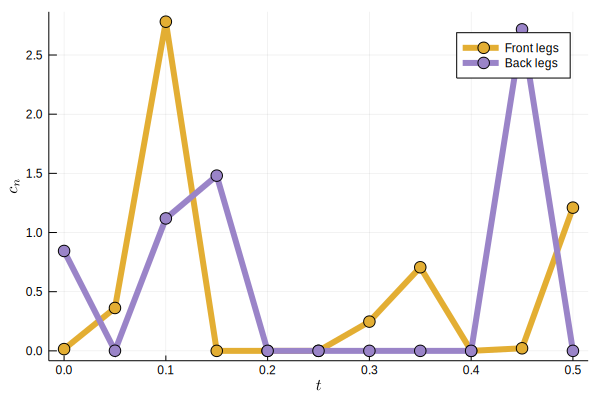

In [144]:
xlabel=latexstring("t")
ylabel=latexstring("c_n")
plot(traj_semidirect[7][1:end-1],front_traj,label="Front legs",seriescolor=RGB(((227,174,51) ./ 255.)...),linewidth=6,marker=6,xlabel=xlabel)
plot!(traj_semidirect[7][1:end-1],back_traj,label="Back legs",seriescolor=RGB(((154,132,200) ./ 255.)...),linewidth=6,marker=6,ylabel=ylabel)

In [ ]:
plot(traj_semidirect[8][16,:])

In [ ]:
savefig(string("littledog.svg")) 

In [ ]:
xlabel=latexstring("x")
ylabel=latexstring("z")
plot(traj_semidirect[8][1,:],-traj_semidirect[8][2,:],front_traj,label="Torso center of mass position",seriescolor=RGB(((127,174,51) ./ 255.)...),linewidth=6,marker=6,xlabel=xlabel,ylabel=ylabel)

In [ ]:
savefig(string("littledogcom.svg")) 

In [ ]:
setanimation!(mvis, traj_semidirect[7], traj_semidirect[1])

In [159]:
t_step = traj_semidirect[7]
q_step = traj_semidirect[1]
u_step = traj_semidirect[2][2:end];

In [160]:
# Multi-steps

reps = 3

ttraj = t_step
qtraj = q_step
utraj = u_step
for i = 1:(reps-1)
    ttraj = vcat(ttraj, t_step .+ ttraj[end])
    qtraj = vcat(qtraj, map(q -> q + vcat(qtraj[end][1],zeros(length(q)-1)), q_step))
    utraj = vcat(utraj, u_step)
end

setanimation!(mvis, ttraj, qtraj)

In [ ]:
# Indirect

sim_data = get_trajopt_data_indirect(mechanism,env,Δt,N,relax_comp=true)
x0, x_min, x_max = setup_prob!(sim_data);

In [ ]:
con_tol = 1e-5
obj_tol = 1e-5
max_iter = 1000

display(@time traj_indirect = Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=1, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter))

x0 = traj_indirect[9]

setanimation!(mvis, traj_indirect[7], traj_indirect[1])

In [ ]:
function run_trajopt()
    Bilevel.solve_rosenbrock() # clearing SNOPT
    Bilevel.trajopt(sim_data, x0=x0, x_min=x_min, x_max=x_max, verbose=0, opt_tol=obj_tol, major_feas=con_tol, minor_feas=con_tol, max_iter=max_iter)
end

@benchmark run_trajopt()

In [ ]:
setanimation!(mvis, traj_indirect[7], traj_indirect[1])

In [ ]:
t_step = traj_indirect[7]
q_step = traj_indirect[1]
u_step = traj_indirect[2][2:end];